In [8]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay)

In [9]:
# 1. Load data

train_path = "/kaggle/input/titanic/train.csv"
test_path  = "/kaggle/input/titanic/test.csv"

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)  # expects columns: Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked

In [10]:
# 2. Minimal cleaning + feature engineering

# --- Feature engineering FIRST ---

# (a) Title from Name
df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()

# Normalize & group rare titles
title_map = {
    # common
    "Mr":"Mr", "Mrs":"Mrs", "Miss":"Miss", "Master":"Master", "Ms":"Miss",
    "Mlle":"Miss", "Mme":"Mrs",
    # officers / clergy
    "Dr":"Officer", "Rev":"Officer", "Col":"Officer", "Major":"Officer",
    "Capt":"Officer",
    # nobility / honorifics
    "Lady":"Royalty", "Countess":"Royalty", "Sir":"Royalty", "Don":"Royalty",
    "Jonkheer":"Royalty", "Dona":"Royalty"
}
df["Title"] = df["Title"].map(title_map).fillna(df["Title"])
rare_titles = df["Title"].value_counts()
df["Title"] = df["Title"].where(df["Title"].isin(rare_titles[rare_titles >= 10].index), "Other")

# (b) Family size
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

# (c) Cabin-based features
df["HasCabin"] = (~df["Cabin"].isna()).astype(int)
df["Deck"] = df["Cabin"].str[0].fillna("U")   # U = Unknown
df = df.drop(columns=["Cabin"])               # drop sparse Cabin

# (d) Ticket group size (rough proxy of group travel)
ticket_counts = df["Ticket"].value_counts()
df["TicketGroupSize"] = df["Ticket"].map(ticket_counts)

# (e) IsAlone indicator
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

# (f) Fare per person
df["FarePerPerson"] = df["Fare"] / df["FamilySize"]

# (g) Age missing indicator
df["AgeMissing"] = df["Age"].isna().astype(int)

# --- 1) Show .head() with engineered features included ---
cols_to_show = [
    "PassengerId","Survived","Pclass","Name","Sex","Age","SibSp","Parch",
    "Ticket","Fare","Embarked",
    "Title","FamilySize","HasCabin","Deck","TicketGroupSize",
    "IsAlone","FarePerPerson","AgeMissing"
]
display(df[cols_to_show].head())

# --- 2) Clean missing-value summary (percentages) ---
missing_summary = (
    df.isna().mean()
      .mul(100).round(2)
      .rename("Missing (%)")
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={"index": "Column"})
)
display(missing_summary.query("`Missing (%)` > 0"))


# Select features & target

target = "Survived"
numeric_features = ["Age", "Fare", "FarePerPerson", "FamilySize", "TicketGroupSize", "Pclass"]
categorical_features = ["Sex", "Embarked", "Title", "HasCabin", "Deck", "IsAlone", "AgeMissing"]

X = df[numeric_features + categorical_features]
y = df[target].astype(int)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,HasCabin,Deck,TicketGroupSize,IsAlone,FarePerPerson,AgeMissing
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,2,0,U,1,0,3.62500,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,2,1,C,1,0,35.64165,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1,0,U,1,1,7.92500,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,2,1,C,2,0,26.55000,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,1,0,U,1,1,8.05000,0


,Column,Missing (%)
0,Age,19.87
1,Embarked,0.22


In [11]:
# 3. Preprocess: impute + one-hot encode categoricals

# For simplicity: use OneHotEncoder(handle_unknown="ignore") and rely on tree's robustness.
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            # trees don't need scaling
        ]), numeric_features),

        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_features),
    ],
    remainder="drop"
)

In [12]:
# 4. Build pipeline: preprocessing -> DecisionTree

tree = DecisionTreeClassifier(random_state=42)
pipe = Pipeline(steps=[("prep", preprocess), ("clf", tree)])

In [13]:
# 5. Train/validation split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Best params: {'clf__ccp_alpha': 0.001, 'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5}
CV best F1: 0.7713444501719184

Best params detail:
  clf__ccp_alpha: 0.001
  clf__class_weight: balanced
  clf__criterion: gini
  clf__max_depth: 8
  clf__max_features: sqrt
  clf__min_samples_leaf: 4
  clf__min_samples_split: 5

Chosen class_weight: balanced

Precision–Recall balance on validation:
  Precision : 0.6790
  Recall    : 0.7971
  F1-score  : 0.7333
  Avg Precision (PR AUC): 0.7301

Detailed report:
              precision    recall  f1-score   support

        Died       0.86      0.76      0.81       110
    Survived       0.68      0.80      0.73        69

    accuracy                           0.78       179
   macro avg       0.77      0.78      0.77       179
weighted avg       0.79      0.78      0.78       179



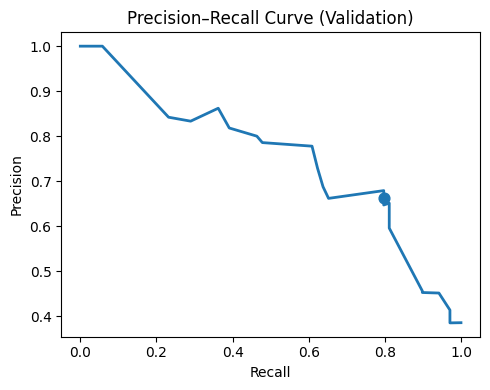

In [14]:
# 6. Hyperparameter search (grid) with 5-fold CV on training set

param_grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [None, 4, 5, 6, 8, 10],
    "clf__min_samples_split": [5, 10, 20],
    "clf__min_samples_leaf": [2, 4, 8],          
    "clf__max_features": [None, "sqrt", "log2"],
    "clf__ccp_alpha": [0.0, 1e-4, 5e-4, 1e-3],   
}

param_grid["clf__class_weight"] = [None, "balanced"]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",   # balanced-ish metric for Titanic
    cv=5,
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("CV best F1:", grid.best_score_)

# Inspect whether class weighting helped
best_params = grid.best_params_
print("\nBest params detail:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

cw = best_params.get("clf__class_weight", None)
print(f"\nChosen class_weight: {cw}")

# ---------- Precision–Recall balance check on validation ----------
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score

# Use the best model found by GridSearchCV on the held-out validation set
y_pred = best_model.predict(X_valid)
y_prob = best_model.predict_proba(X_valid)[:, 1]

prec = precision_score(y_valid, y_pred)
rec  = recall_score(y_valid, y_pred)
f1   = f1_score(y_valid, y_pred)
ap   = average_precision_score(y_valid, y_prob)  # area under PR curve

print(f"\nPrecision–Recall balance on validation:")
print(f"  Precision : {prec:.4f}")
print(f"  Recall    : {rec:.4f}")
print(f"  F1-score  : {f1:.4f}")
print(f"  Avg Precision (PR AUC): {ap:.4f}")

print("\nDetailed report:")
print(classification_report(y_valid, y_pred, target_names=['Died','Survived']))

# Plot Precision–Recall curve and mark the default 0.5 threshold point
ps, rs, ths = precision_recall_curve(y_valid, y_prob)

plt.figure(figsize=(5,4))
plt.plot(rs, ps, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")

# mark operating point at threshold 0.5
# find index closest to 0.5 threshold in 'ths' (note: ps, rs have len = len(ths)+1)
import numpy as np
idx = (np.abs(ths - 0.5)).argmin()
plt.scatter(rs[idx], ps[idx], s=60, marker='o')
plt.tight_layout()
plt.show()


Validation metrics:
  Accuracy  : 0.7765
  Precision : 0.6790
  Recall    : 0.7971
  F1-score  : 0.7333
  ROC-AUC   : 0.8042


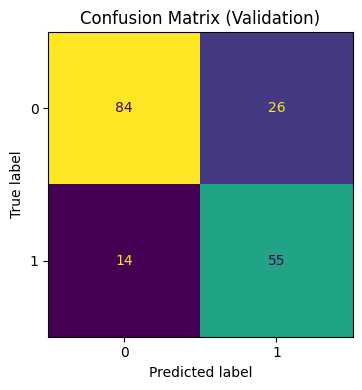

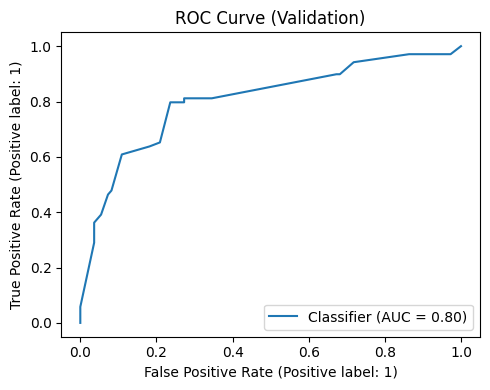

In [15]:
# 7. Evaluation on validation set

y_pred = best_model.predict(X_valid)
y_prob = best_model.predict_proba(X_valid)[:, 1]

acc  = accuracy_score(y_valid, y_pred)
prec = precision_score(y_valid, y_pred)
rec  = recall_score(y_valid, y_pred)
f1   = f1_score(y_valid, y_pred)
auc  = roc_auc_score(y_valid, y_prob)

print(f"\nValidation metrics:\n"
      f"  Accuracy  : {acc:.4f}\n"
      f"  Precision : {prec:.4f}\n"
      f"  Recall    : {rec:.4f}\n"
      f"  F1-score  : {f1:.4f}\n"
      f"  ROC-AUC   : {auc:.4f}")

# Confusion matrix
fig, ax = plt.subplots(figsize=(4.5,4))
ConfusionMatrixDisplay(confusion_matrix(y_valid, y_pred)).plot(ax=ax, colorbar=False)
ax.set_title("Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

# ROC curve
fig, ax = plt.subplots(figsize=(5,4))
RocCurveDisplay.from_predictions(y_valid, y_prob, ax=ax)
ax.set_title("ROC Curve (Validation)")
plt.tight_layout()
plt.show()


Top 15 feature importances:
 Title_Mr           0.490525
HasCabin_1         0.221923
FamilySize         0.100557
FarePerPerson      0.060688
IsAlone_0          0.041173
Fare               0.025363
Age                0.018295
Deck_B             0.017731
Title_Master       0.007742
Title_Officer      0.005640
Embarked_S         0.005446
TicketGroupSize    0.003682
AgeMissing_1       0.000807
Deck_C             0.000428
Title_Miss         0.000000
dtype: float64


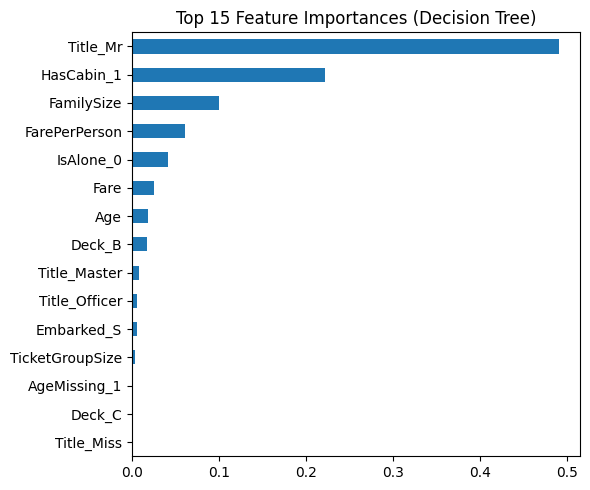

In [16]:
# 8. Feature importance

# To extract feature names after one-hot:
ohe = best_model.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_names

importances = best_model.named_steps["clf"].feature_importances_
imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nTop 15 feature importances:\n", imp.head(15))

fig, ax = plt.subplots(figsize=(6,5))
imp.head(15).sort_values().plot(kind="barh", ax=ax)
ax.set_title("Top 15 Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()


Pruning sweep (ccp_alpha vs F1):
    ccp_alpha        F1
0   0.000000  0.728682
1   0.005282  0.713178
2   0.010563  0.657143
3   0.015845  0.657143
4   0.021126  0.683544


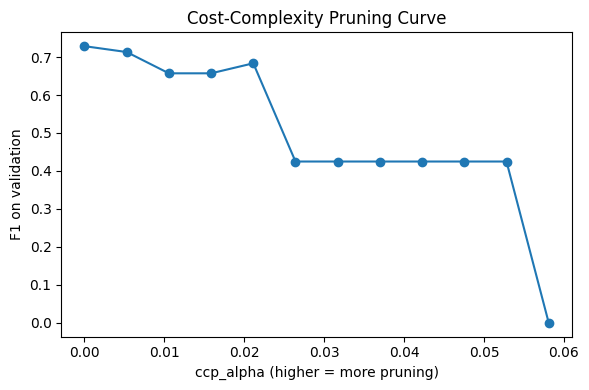

In [17]:
# 9. Cost-Complexity Pruning (ccp_alpha)

# Fit a large tree first (copy best params, but remove max_depth to allow growth)
large_tree = DecisionTreeClassifier(
    random_state=42,
    criterion=best_model.named_steps["clf"].criterion,
    min_samples_split=best_model.named_steps["clf"].min_samples_split,
    min_samples_leaf=best_model.named_steps["clf"].min_samples_leaf,
    max_features=best_model.named_steps["clf"].max_features
)
large_pipe = Pipeline([("prep", preprocess), ("clf", large_tree)])
large_pipe.fit(X_train, y_train)

# Obtain effective alphas for pruning
path = large_pipe.named_steps["clf"].cost_complexity_pruning_path(
    large_pipe.named_steps["prep"].fit_transform(X_train), y_train
)
ccp_alphas = path.ccp_alphas

# Evaluate a few pruned trees
records = []
for a in np.linspace(ccp_alphas.min(), ccp_alphas.max(), 12):
    clf = DecisionTreeClassifier(
        random_state=42,
        criterion=best_model.named_steps["clf"].criterion,
        min_samples_split=best_model.named_steps["clf"].min_samples_split,
        min_samples_leaf=best_model.named_steps["clf"].min_samples_leaf,
        max_features=best_model.named_steps["clf"].max_features,
        ccp_alpha=a
    )
    pipe_a = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe_a.fit(X_train, y_train)
    y_hat = pipe_a.predict(X_valid)
    f1_a = f1_score(y_valid, y_hat)
    records.append((a, f1_a))

prune_df = pd.DataFrame(records, columns=["ccp_alpha", "F1"])
print("\nPruning sweep (ccp_alpha vs F1):\n", prune_df.head())

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(prune_df["ccp_alpha"], prune_df["F1"], marker="o")
ax.set_xlabel("ccp_alpha (higher = more pruning)")
ax.set_ylabel("F1 on validation")
ax.set_title("Cost-Complexity Pruning Curve")
plt.tight_layout()
plt.show()

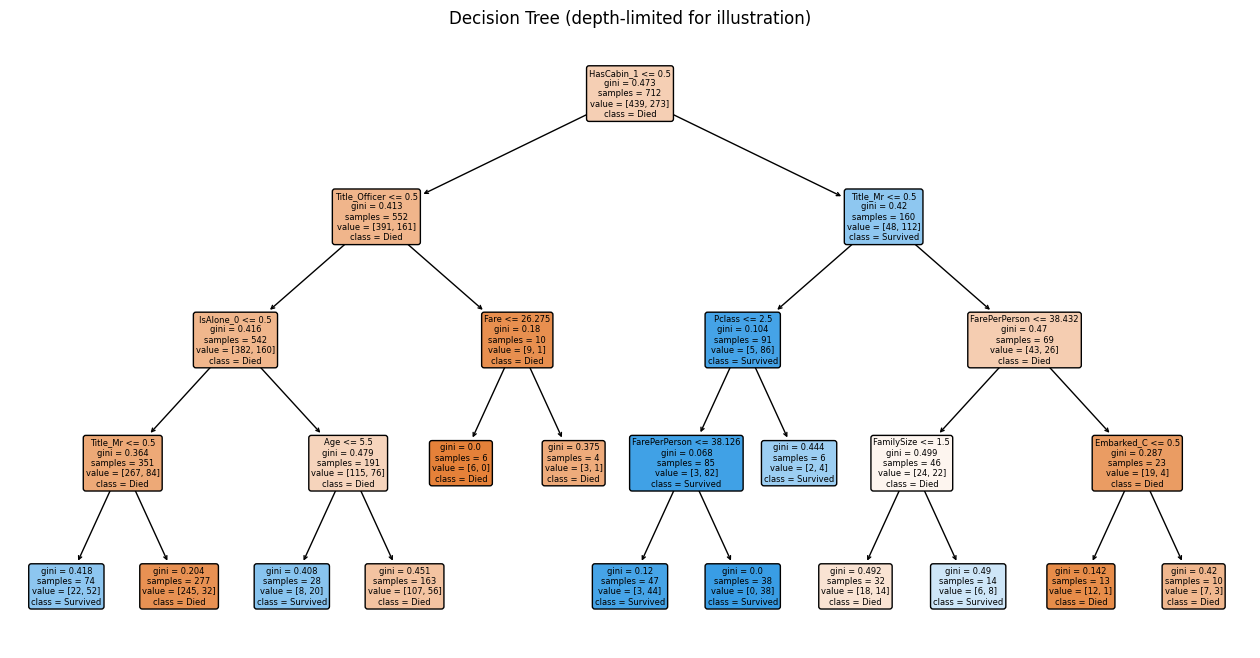

In [18]:
# 10. Visualize final tree (small depth for readability)

small_tree = DecisionTreeClassifier(
    random_state=42,
    max_depth=4,
    criterion=best_model.named_steps["clf"].criterion,
    min_samples_split=best_model.named_steps["clf"].min_samples_split,
    min_samples_leaf=best_model.named_steps["clf"].min_samples_leaf,
    max_features=best_model.named_steps["clf"].max_features
)
small_pipe = Pipeline([("prep", preprocess), ("clf", small_tree)])
small_pipe.fit(X_train, y_train)

X_fit = small_pipe.named_steps["prep"].transform(X_train)
plt.figure(figsize=(16,8))
plot_tree(
    small_pipe.named_steps["clf"],
    feature_names=feature_names,
    class_names=["Died","Survived"],
    filled=True, rounded=True, max_depth=4
)
plt.title("Decision Tree (depth-limited for illustration)")
plt.show()

In [19]:
# 11. Final train on ALL of train.csv, predict test.csv, save submission.csv

def engineer_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    # match earlier feature engineering
    df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["HasCabin"] = (~df["Cabin"].isna()).astype(int)
    return df

# fresh loads (avoid any leakage from split objects above)
train_full = pd.read_csv("/kaggle/input/titanic/train.csv")
test_full  = pd.read_csv("/kaggle/input/titanic/test.csv")

# apply feature engineering
train_full = engineer_features(train_full)
test_full  = engineer_features(test_full)

# ticket group size computed using both (acceptable for Kaggle/test-time inference)
both_tickets = pd.concat([train_full[["Ticket"]], test_full[["Ticket"]]], ignore_index=True)
ticket_counts_all = both_tickets["Ticket"].value_counts()
train_full["TicketGroupSize"] = train_full["Ticket"].map(ticket_counts_all)
test_full["TicketGroupSize"]  = test_full["Ticket"].map(ticket_counts_all)

# reuse your feature lists from above
numeric_features = ["Age", "Fare", "FamilySize", "TicketGroupSize", "Pclass"]
categorical_features = ["Sex", "Embarked", "Title", "HasCabin"]

X_full = train_full[numeric_features + categorical_features]
y_full = train_full["Survived"].astype(int)
X_test = test_full[numeric_features + categorical_features]

# build final pipeline using the BEST PARAMS you found
final_tree = DecisionTreeClassifier(
    random_state=42,
    criterion=grid.best_params_["clf__criterion"],
    max_depth=grid.best_params_["clf__max_depth"],
    min_samples_split=grid.best_params_["clf__min_samples_split"],
    min_samples_leaf=grid.best_params_["clf__min_samples_leaf"],
    max_features=grid.best_params_["clf__max_features"],
)

final_preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
        ]), numeric_features),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_features),
    ],
    remainder="drop"
)

final_pipe = Pipeline([("prep", final_preprocess), ("clf", final_tree)])
final_pipe.fit(X_full, y_full)

# predict on test.csv
test_pred = final_pipe.predict(X_test).astype(int)

# make submission
submission = pd.DataFrame({
    "PassengerId": test_full["PassengerId"],
    "Survived": test_pred
})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")
print(submission.head())

Saved submission.csv
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
